In [1]:
#Imports for Puyo environment
import gym
from gym import spaces
import pygame
import numpy as np
import math
import setuptools

C:\Users\Sean Braswell\AppData\Roaming\Python\Python39\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
#The Puyo environment, made using the example on the gym documentation as reference
class PuyoEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    
    def __init__(self, render_mode=None):
        #game logic stuff
        self.num_colors = 4 #number of unique colors
        self.current_piece = self.get_new_piece()
        self.board = np.zeros((5, 12)) #12x5 grid, board[x][y] coordinates starting from top-right
        self.score = 0
        self.update_board()
        self.score_calc_table = {"chain power": [0, 0, 8, 16, 32, 64, 128, 256, 512, 999],
                                "color bonus": [0, 0, 3, 6, 12],
                                "group bonus": [0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 7, 10]}
        self.time = 1
        self.stall_penalty = -20000
        self.loss_penalty = -10000
        self.legal_reward = 5
        self.recent_actions = []
        
        #environment stuff
        #NOTE: THIS ISN'T ACCURATE ANYMORE
        self.observation_space = (np.full((5, 12), spaces.Box(0, self.num_colors, shape=(1,), dtype=int), dtype=spaces.Box), 
                                 {"coordinates": tuple(np.full((2,2), spaces.Box(0, 11, shape=(1,), dtype=int))),
                                 "colors": [spaces.Box(1, self.num_colors+1, shape=(1,)), spaces.Box(1, self.num_colors+1, shape=(1,))]})
        self.action_space = spaces.Discrete(4) #left, right, rotate, down
        
        #pygame stuff
        self.window_size = 512 #pygame window size
        self.render_mode = render_mode
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.window = None #Window used for human rendering
        self.clock = None #clcok to ensure envrionment is rendered at correct frame rate in human rendering mode
    
    def _get_obs(self):
        #obs is a 1D array consisting of the board, followed by current_piece coordinates and current_piece colors
        obs = self.board.flatten()
        #print(len(obs))
        #for column in self.board:
        #    for space in column:
        #        obs.append(space)
        #obs.append(self.current_piece["coordinates"][0])
        #obs.append(self.current_piece["coordinates"][1])
        #obs.append(self.current_piece["colors"][0])
        #obs.append(self.current_piece["colors"][1])
        obs = np.append(obs, self.current_piece["coordinates"][0])
        #obs = np.append(obs, self.current_piece["coordinates"][0][1])
        #print(len(obs))
        obs = np.append(obs, self.current_piece["coordinates"][1])
        #obs = np.append(obs, self.current_piece["coordinates"][1][1])
        #print(len(obs))
        obs = np.append(obs, self.current_piece["colors"][0])
        #print(len(obs))
        obs = np.append(obs, self.current_piece["colors"][1])
        #print(len(obs))
        return obs
        #return (self.board, self.current_piece) #Returns (board, {piece coordinates, piece colors})
    
    def _get_info(self): #Currently not needed, so just returns an empty dictionary
        return {}
    
    #Returns a new current_piece
    def get_new_piece(self):
        self.recent_actions = []
        return {"coordinates": ([2, 0], [2, 1]), 
                "colors": [np.random.randint(1, self.num_colors+1), np.random.randint(1, self.num_colors+1)]}
    
    #Updates the location of the current_piece onto the board
    def update_board(self):
        self.board[self.current_piece["coordinates"][0][0]][self.current_piece["coordinates"][0][1]] = self.current_piece["colors"][0]
        self.board[self.current_piece["coordinates"][1][0]][self.current_piece["coordinates"][1][1]] = self.current_piece["colors"][1]
        
    def reset(self, seed=None, options=None):
        #super().reset(seed=seed)
        #NOTE: I'M NOT USING THE ENVIRONMENT RNG BECAUSE I CAN'T FIND THE DOCUMENTATION, SO I MIGHT HAVE TO DO SEED SHENANIGANS
        self.current_piece = self.get_new_piece()
        self.board = np.zeros((5, 12))
        self.update_board()
        self.score = 0
        self.recent_actions = []
        
        observation = self._get_obs()
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
            
        return observation, info
    
    #TODO: FINISH THIS
    def step(self, action):
        #Actions are 0, 1, 2, 3 for left, right, rotate, drop, respectively
        reward = 0 #0 by default, matching puyos in case 3 will change it
        terminated = False #false by default, if dropping leads to a fail, will change
        fail_check = False
        #Take action
        self.recent_actions.append(action) #Needed for checking for anti-stalling penalty
        if action == 0: #move left
            reward = self.move_left()
        elif action == 1: #move right
            reward = self.move_right()
        elif action == 2: #rotate piece
            reward = self.rotate_piece()
        elif action == 3: #drop piece
            reward = self.gravity()
            fail_check = True
        else:
            raise ValueError("Invalid action taken!  Input should be between 0-3")

        #Calculate reward
        #return all necessary information
        observation = self._get_obs()
        info = self._get_info()
        
        #Do autofall
        self.time += 1
        if self.time % 4 == 0 and fail_check == False:
            self.time = 1
            #make piece fall if it can (REMEMBER TO CONSIDER OUT OF BOUNDS STUFF)
            piece1 = self.current_piece["coordinates"][0]
            piece2 = self.current_piece["coordinates"][1]
            if piece1[0] != piece2[0]: #piece is positioned horizontally
                if piece1[1] == 11: #bottom of board, lock in place
                    fail_check = True
                    reward = self.gravity()
                else: #piece is above position 11, check to see if it can fall a space
                    if self.board[piece1[0]][piece1[1]+1] == 0 and self.board[piece2[0]][piece2[1]+1] == 0: #piece can fall
                        self.board[piece1[0]][piece1[1]] = 0
                        self.board[piece2[0]][piece2[1]] = 0
                        self.current_piece["coordinates"][0][1] += 1
                        self.current_piece["coordinates"][1][1] += 1
                        self.update_board()
                    else: #piece can't fall
                        fail_check = True
                        reward = self.gravity()
            else: #piece is positioned vertically
                lowest_piece = 0 if piece1[1] > piece2[1] else 1
                if self.current_piece["coordinates"][lowest_piece][1] == 11: #Bottom of board, lock in place
                    fail_check = True
                    reward = self.gravity()
                else: #Piece above position 11, check to see if it can fall a space
                    #print(f"lowest piece is #{lowest_piece}")
                    if self.board[self.current_piece["coordinates"][lowest_piece][0]][self.current_piece["coordinates"][lowest_piece][1]+1] == 0: #piece can fall a space
                        #print("Going down 1")
                        other_piece = 0 if lowest_piece == 1 else 1
                        self.board[piece1[0]][piece1[1]] = 0
                        self.board[piece2[0]][piece2[1]] = 0
                        self.current_piece["coordinates"][lowest_piece][1] += 1
                        self.current_piece["coordinates"][other_piece][1] += 1
                        self.update_board()
                    else: #piece can't fall 
                        #print("piece can't fall!")
                        fail_check = True
                        reward = self.gravity()
        
        #Check for fail only after setting a piece, ie through gravity or autofall clicked a piece into place
        #Autofall will mess with this
        if fail_check == True:
            if self.board[2][1] != 0:
                terminated = True
                reward = self.loss_penalty
            self.current_piece = self.get_new_piece()
            self.update_board()

        if self.render_mode == "human":
            self.render_frame()
        
        if reward == 0: #Legal move done, no matching took place
            reward = self.legal_reward 
        
        #NOTE: THIS PART MAY WANT TO BE COMMENTED OUT ONCE THE AI IS WORKING
        #self.score += reward
        return observation, reward, terminated, False, info
    
    #Tries to move the current piece to the left
    def move_left(self):
        #Check for stalling
        reward = 0
        if 1 in self.recent_actions:
            reward += self.stall_penalty
        #Move left
        piece_coords = self.current_piece["coordinates"]
        #If horizontal, check for collision against the farthest to the left (greatest x value)
        if piece_coords[0][1] == piece_coords[1][1]:
            x_to_check = max(piece_coords[0][0], piece_coords[1][0])
            if x_to_check < 4 and self.board[x_to_check+1][piece_coords[0][1]] == 0:
                self.move_left_helper(piece_coords)
            else:
                reward += self.stall_penalty
        #Not horizontal, need to check both x coordinates
        elif piece_coords[0][0] < 4 and piece_coords[1][0] < 4 and self.board[piece_coords[0][0]+1][piece_coords[0][1]] == 0 and self.board[piece_coords[1][0]+1][piece_coords[1][1]] == 0:
            self.move_left_helper(piece_coords)
        else:
            reward += self.stall_penalty
        return reward
    
    def move_left_helper(self, piece_coords):
            #Remove the current_piece off the board
            self.board[piece_coords[0][0]][piece_coords[0][1]] = 0
            self.board[piece_coords[1][0]][piece_coords[1][1]] = 0
            #Update coordinates of current piece
            self.current_piece["coordinates"][0][0] += 1
            self.current_piece["coordinates"][1][0] += 1
            #update the board
            self.update_board()                               
    
    def move_right(self):
        #Check fo rstalling
        reward = 0
        if 0 in self.recent_actions:
            reward += self.stall_penalty
        #Move right
        piece_coords = self.current_piece["coordinates"]
        #If horizontal, check for collision against farthest to the right (smallest x value)
        if piece_coords[0][1] == piece_coords[1][1]:
            x_to_check = min(piece_coords[0][0], piece_coords[1][0])
            if x_to_check > 0 and self.board[x_to_check-1][piece_coords[0][1]] == 0:
                self.move_right_helper(piece_coords)
            else:
                reward += self.stall_penalty
        #Not horizontal, need to check both x coordinates
        elif piece_coords[0][0] > 0 and piece_coords[1][0] > 0 and self.board[piece_coords[0][0]-1][piece_coords[0][1]] == 0 and self.board[piece_coords[1][0]-1][piece_coords[1][1]] == 0:
            self.move_right_helper(piece_coords)
        else:
            reward += self.stall_penalty
        return reward
            
    def move_right_helper(self, piece_coords):
        #Remove the current_piece off the board
        self.board[piece_coords[0][0]][piece_coords[0][1]] = 0
        self.board[piece_coords[1][0]][piece_coords[1][1]] = 0
        #Update coordinates of current piece
        self.current_piece["coordinates"][0][0] -= 1
        self.current_piece["coordinates"][1][0] -= 1
        #update the board
        self.update_board()
    
    def rotate_piece(self):
        #Check for stalling
        reward = 0
        if self.recent_actions.count(2) >= 4:
            reward += self.stall_penalty
        #The first piece always rotates counter-clockwise around the second piece, so only the first piece will move
        #Calculate new piece position
        angle = math.radians(90)
        piece1 = self.current_piece["coordinates"][0]
        piece2 = self.current_piece["coordinates"][1]
        new_piece1x = round(math.cos(angle) * (piece1[0] - piece2[0]) - math.sin(angle) * (piece1[1] - piece2[1]) + piece2[0])
        new_piece1y = round(math.sin(angle) * (piece1[0] - piece2[0]) + math.cos(angle) * (piece1[1] - piece2[1]) + piece2[1])
        #Check if inbounds and not colliding
        if new_piece1x >= 0 and new_piece1x <= 4 and new_piece1y >= 0 and new_piece1y <= 11 and self.board[new_piece1x][new_piece1y] == 0:
            #Erase current_piece1 off board (since piece 2 doesn't move)
            self.board[piece1[0]][piece1[1]] = 0
            #Set piece position to new position
            self.current_piece["coordinates"][0][0] = new_piece1x
            self.current_piece["coordinates"][0][1] = new_piece1y
            #Update the board
            self.update_board()
        else:
            reward += self.stall_penalty
        return reward
            
    #TODO: FINISH THIS HERE
    def gravity(self):
        terminated = False
        reward = 0
        repeat_gravity = True
        chain_info = {"chain length": 0,
                     "unique colors": [],
                     "puyos cleared": 0}

        while repeat_gravity:
            repeat_gravity = False
            #Make stuff fall down (and erase it from it was already was), MAKE SURE TO START AT BOTTOM FOR EACH COLUMN
            for column in self.board:
                self.puyo_fall(column)
            #Check for matched puyos
            #If puyos match, calculate reward gain and repeat_gravity
            repeat_gravity, reward_gain = self.match_puyos(chain_info)
            reward += reward_gain
        #Add reward to cumulative score
        self.score += reward
        #Loss condition checked in a different function because I have to change stuff so this code is getting cursed
        #Get a new piece has been moved to step with fail_check
        return reward
    
    #Given a 1D array x, make all puyos fall to the bottom
    def puyo_fall(self, x):
        swap = []
        for i in range(len(x)-1, -1, -1):
            if(x[i] == 0):
                swap.append(i)
            elif(x[i] != 0 and swap != []):
                tmp = x[i]
                x[i] = 0
                x[swap.pop(0)] = tmp
                swap.append(i)
    
    #Check to see if 4+ puyos connect, and if so remove them and calculate score
    def match_puyos(self, chain_info):
        puyos_matched = False
        checked_list = []
        matched_groups = []
        reward_gain = 0
        for c in range(0, len(self.board)):
            for r in range(0, len(self.board[c])):
                #For each piece that isn't a 0 (and not already part of a known connection, recursively check adjacent pieces
                if self.board[c][r] != 0 and [c,r] not in checked_list:
                    connected_puyos = self.find_connected([c, r], [[c, r]])
                    for pair in connected_puyos:
                        checked_list.append(pair)
                    if len(connected_puyos) >= 4: #Add to list of connections found
                        matched_groups.append(sorted(connected_puyos))
        #Make puyos disappear and give points
        if matched_groups != []:
            chain_info["chain length"] += 1
            puyos_matched = True
            group_totals = 0
            for match in matched_groups:
                chain_info["puyos cleared"] += len(match)
                color = self.board[match[0][0]][match[0][1]]
                if color not in chain_info["unique colors"]:
                    chain_info["unique colors"].append(color)
                group_totals += len(match)
                for piece in match:
                    self.board[piece[0]][piece[1]] = 0
            reward_gain = self.calculate_score_gain(chain_info, group_totals)
        return puyos_matched, reward_gain
    
    #For a given c,r (x,y) value, find the coordinates of connected puyos of the same color
    def find_connected(self, pair, connected_list):
        #Check color of adjacent puyo, and if it matches, then place in connected_list and recurse on that point
        c = pair[0]
        r = pair[1]
        if r > 0: #y value in bounds
            if [c, r-1] not in connected_list and self.board[c][r-1] == self.board[c][r]:
                connected_list.append([c, r-1])
                self.find_connected([c, r-1], connected_list)
        #Check down
        if r < 11: #y in bounds
            if [c,r+1] not in connected_list and self.board[c][r+1] == self.board[c][r]:
                connected_list.append([c, r+1])
                self.find_connected([c, r+1], connected_list)
        #Check left
        if c < 4:
            if [c+1,r] not in connected_list and self.board[c+1][r] == self.board[c][r]:
                connected_list.append([c+1, r])
                self.find_connected([c+1, r], connected_list)
        #Check right
        if c > 0:
            if [c-1, r] not in connected_list and self.board[c-1][r] == self.board[c][r]:
                connected_list.append([c-1, r])
                self.find_connected([c-1, r], connected_list)
        return connected_list
    
    #Given the current information about a chain and the total for the group bonus, calculate how much score should be awarded
    def calculate_score_gain(self, chain_info, group_totals):
        PC = chain_info["puyos cleared"]
        CP = self.score_calc_table["chain power"][chain_info["chain length"]] if chain_info["chain length"] < 10 else 999
        CB = self.score_calc_table["color bonus"][len(chain_info["unique colors"])]
        GB = self.score_calc_table["group bonus"][group_totals] if group_totals < 12 else 10
        bonus_totals = self.clip_into_range(CP+CB+GB, 1, 999)
        return (10*PC) * bonus_totals
        
    def clip_into_range(self, item, lower_bound, upper_bound):
        if item < lower_bound:
            return lower_bound
        elif item > upper_bound:
            return upper_bound
        return item
    
    #Shenanigans for later
    def _render_frame(self):
        return 0
        

In [3]:
#Environment testing
x = PuyoEnv()
#Need to test rotation after auto-fall implemented, then need to test auto-fall edge cases
s, reward, t, F, i = x.step(1)
print(x.board, reward)
s, reward, t, F, i = x.step(1)
print(x.board, reward)
s, reward, t, F, i = x.step(0)
print(x.board, reward)
s, reward, t, F, i = x.step(2)
print(x.board, reward)
s, reward, t, F, i = x.step(2)
print(x.board, reward)
s, reward, t, F, i = x.step(2)
print(x.board, reward)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 5
[[1. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 5
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] -20000
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 5
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 5
[[0. 

In [68]:
#Register the environment
gym.envs.registration.register(
    id="gym_examples/Puyo",
    entry_point="gym_examples.envs:PuyoEnv")

In [77]:
#idk why this isn't working and it's frustrating so I'm just gonna use the environment class I wrote above
#setuptools.setup(
    #name="gym_examples",
    #version="0.0.1",
    #install_requires=["gym==0.26.0", "pygame==2.1.0"])

In [69]:
#AI time

In [4]:
#Imports for AI, using the homework as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import copy


C:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
env = PuyoEnv()

cpu


In [6]:
#I don't really know what layers to use for the neural network, so this will probably change later
class Policy(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #return F.softmax(x, dim=1)
        return F.softmax(x)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        #robs = self.forward(state).cpu()
        # = Categorical(probs)
        #ction = m.sample()
        #return action.item(), m.log_prob(action)
        #eturn action.item()
        return torch.argmax(self.forward(state))

In [8]:
#Epsilon Greedy policy that forces exploration.  Idk if it will do anything or not.
class EpsilonPolicy(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(EpsilonPolicy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.train = True
        self.max_epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon = 1.0
        self.decay_rate = 0.005
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)
    
    def act(self, state):
        if self.train == True and np.random.rand() < self.epsilon:
            #Exploration: Choose random action that doesn't invoke a penalty
            possible_actions = self.get_actions()
            action = np.random.randint(0, len(possible_actions))
        else:
            #Exploitation: Choose best action evaluated by neural net
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            action = torch.argmax(self.forward(state))
        return action
    
    def get_actions(self):
        possible_actions = [0,1,2,3]
        recent_actions = env.recent_actions
        
        if 0 in recent_actions:
            possible_actions.remove(1)
        if 1 in recent_actions:
            possible_actions.remove(0)
        if recent_actions.count(2) >=3:
            possible_actions.remove(2)
        
        return possible_actions

In [9]:
#The updated version with a replay buffer and target/model network
#target network is used for action selection, and primary network is used for evaluation
def double_q_v2(target_net, net2, optimizer, n_training_episodes, time_limit, gamma, avg_rate, print_every):
    cumulative_scores = []
    #copy_net = copy.deepcopy(target_net)
    copy_net = net2
    
    for i in range(1, n_training_episodes+1):
        state, _ = env.reset()
        replay_buffer = []
        
        #For Epsilon-Greedy Policy only
        #target_net.epsilon = target_net.min_epsilon + (target_net.max_epsilon - target_net.min_epsilon)*np.exp(-target_net.decay_rate*i)
        
        #Do the double q algorithm
        #play the game
        for t in range(time_limit):
            old_state = state
            #Select action
            action = target_net.act(state)
            #action, log_prob = target_net.act(state)
            #Execture action and receive reward
            new_state, reward, terminated, _, info = env.step(action)
            #Store the state, action, reward, and next state in the replay_buffer
            replay_buffer.append((old_state, action, reward, new_state))
            
            #Check if the game is over
            if terminated == True:
                break
            
        #Update based on game
        for replay in replay_buffer:
            old_state, action, reward, new_state = replay
            #Compute target Q value, R_t + gamma * Q_c(s_t1, argmax Q(s_t1,a))
            new_state_tensor = torch.from_numpy(new_state).float()
            old_state_tensor = torch.from_numpy(old_state).float()
            
            #IMPORTANT: IF THE POLICY CHANGES, THIS NEEDS TO CHANGE TOO 
            
            q_star = reward + (gamma*copy_net.forward(new_state_tensor)[target_net.act(new_state)])
            #Perform gradient descent
            #NOTE: IDK IF THIS WORKS OR NOT
            mse = torch.tensor(( q_star - (copy_net.forward(old_state_tensor)[action]) )**2, requires_grad=True)
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
            #Update target network parameters (should be done at end of episode I think, unless doing polyak averaging)
            #NOTE: DO POLYAK AVERAGING HERE INSTEAD OF COPYING THE NETWORK AT THE END OF THE EPISODE
            for target_param, copy_param in zip(target_net.parameters(), copy_net.parameters()):
                target_param.data.copy_((avg_rate * copy_param) + (1-avg_rate)*target_param)
        
        #End of episode
        #copy_net = copy.copy(target_net)
        #copy_net = copy.deepcopy(target_net)
        cumulative_scores.append(env.score)
        if i % print_every == 0:
            #NOTE: CONSIDER PRINTING THE AVERAGE SCORE OF THE PAST X EPISODES TO GET A MORE ACCURATE ESTIMATION
            print(f"Episode {i}\tScore: {env.score}")

    return cumulative_scores

In [10]:
#Clipped Double Q-Learning
def clipped_double_q(net1, net2, optimizer1, optimizer2, n_training_episodes, time_limit, gamma, avg_rate, print_every):
    cumulative_scores = []
    
    for i in range(1, n_training_episodes+1):
        state, _ = env.reset()
        replay_buffer = []
        
        #For Epsilon-Greedy Policy only
        #net1.epsilon = net1.min_epsilon + (net1.max_epsilon - net1.min_epsilon)*np.exp(-net1.decay_rate*i)
        #net2.epsilon = net2.min_epsilon + (net2.max_epsilon - net2.min_epsilon)*np.exp(-net2.decay_rate*i)
        
        #Do the double q algorithm
        #play the game
        for t in range(time_limit):
            old_state = state
            #Select action
            action = net1.act(state)
            #action, log_prob = target_net.act(state)
            #Execture action and receive reward
            new_state, reward, terminated, _, info = env.step(action)
            #Store the state, action, reward, and next state in the replay_buffer
            replay_buffer.append((old_state, action, reward, new_state))
            
            #Check if the game is over
            if terminated == True:
                break
            
        #Update based on game
        for replay in replay_buffer:
            old_state, action, reward, new_state = replay
            #Compute target Q value, R_t + gamma * Q_c(s_t1, argmax Q(s_t1,a))
            new_state_tensor = torch.from_numpy(new_state).float()
            old_state_tensor = torch.from_numpy(old_state).float()
            
            #IMPORTANT: IF THE POLICY CHANGES, THIS NEEDS TO CHANGE TOO 
            q1_action = net1.act(new_state) #gives argmax of highest q value
            q1_q = net1.forward(new_state_tensor)[q1_action]
            q2_q = net2.forward(new_state_tensor)[q1_action]
            min_q = min(q1_q, q2_q)
            q_star = reward + (gamma*min_q)
            
            #Perform gradient descent
            #NOTE: IDK IF THIS WORKS OR NOT
            mse1 = torch.tensor(( q_star - q1_q )**2, requires_grad=True)
            mse2 = torch.tensor(( q_star - q2_q )**2, requires_grad=True)
            
            optimizer1.zero_grad()
            mse1.backward()
            optimizer1.step()
            
            optimizer2.zero_grad()
            mse2.backward()
            optimizer2.step()
            #Update target network parameters (idk if this is needed anymore, it actually performed better without it)
            #for target_param, net2_param in zip(target_net.parameters(), net2.parameters()):
            #    target_param.data.copy_((avg_rate * net2_param) + (1-avg_rate)*target_param)
        
        #End of episode
        #copy_net = copy.copy(target_net)
        #copy_net = copy.deepcopy(target_net)
        cumulative_scores.append(env.score)
        if i % print_every == 0:
            #NOTE: CONSIDER PRINTING THE AVERAGE SCORE OF THE PAST X EPISODES TO GET A MORE ACCURATE ESTIMATION
            print(f"Episode {i}\tScore: {env.score}")
        
    return cumulative_scores

In [11]:
dqn_hyperparams = {
    "hidden_size": 128,
    "n_training_episodes": 20000,
    "time_limit": 30000,
    "gamma": 0.99,
    "avg_rate": 0.01
}

<ipython-input-6-01ec47aa7539>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
<ipython-input-9-3b4f521cb672>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = torch.tensor(( q_star - (copy_net.forward(old_state_tensor)[action]) )**2, requires_grad=True)


Episode 1000	Score: 80
Episode 2000	Score: 40
Episode 3000	Score: 1210
Episode 4000	Score: 180
Episode 5000	Score: 100
Episode 6000	Score: 5820
Episode 7000	Score: 40
Episode 8000	Score: 1250
Episode 9000	Score: 40
Episode 10000	Score: 5900
Episode 11000	Score: 8690
Episode 12000	Score: 1710
Episode 13000	Score: 1210
Episode 14000	Score: 1100
Episode 15000	Score: 200
Episode 16000	Score: 100
Episode 17000	Score: 120
Episode 18000	Score: 0
Episode 19000	Score: 120
Episode 20000	Score: 920


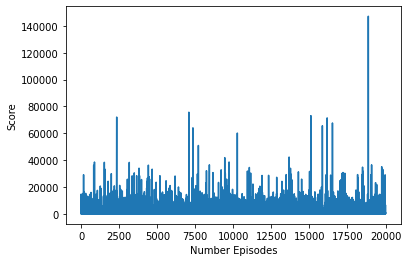

1371.538


In [12]:
#Initialize a network, function parameters and train with double_q_v2 and look at score results, as well as final score
# Standard DDQN
target_net = Policy(66, 4, dqn_hyperparams["hidden_size"])
model_net = Policy(66, 4, dqn_hyperparams["hidden_size"])
#target_net = EpsilonPolicy(66, 4, dqn_hyperparams["hidden_size"])
optimizer = torch.optim.Adam(target_net.parameters())

scores = double_q_v2(target_net, model_net, optimizer, dqn_hyperparams["n_training_episodes"], dqn_hyperparams["time_limit"],
            dqn_hyperparams["gamma"], dqn_hyperparams["avg_rate"], 1000)

plt.plot(scores)
#plt.scatter([i for i in range(1, len(scores)+1)], scores)
plt.ylabel("Score")
plt.xlabel("Number Episodes")
plt.show()
print(sum(scores)/len(scores))

<ipython-input-6-01ec47aa7539>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
<ipython-input-10-7869bc47406e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse1 = torch.tensor(( q_star - q1_q )**2, requires_grad=True)
<ipython-input-10-7869bc47406e>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse2 = torch.tensor(( q_star - q2_q )**2, requires_grad=True)


Episode 1000	Score: 40
Episode 2000	Score: 180
Episode 3000	Score: 2170
Episode 4000	Score: 1520
Episode 5000	Score: 0
Episode 6000	Score: 1120
Episode 7000	Score: 0
Episode 8000	Score: 0
Episode 9000	Score: 0
Episode 10000	Score: 40
Episode 11000	Score: 0
Episode 12000	Score: 0
Episode 13000	Score: 2300
Episode 14000	Score: 40
Episode 15000	Score: 80
Episode 16000	Score: 0
Episode 17000	Score: 0
Episode 18000	Score: 0
Episode 19000	Score: 0
Episode 20000	Score: 220


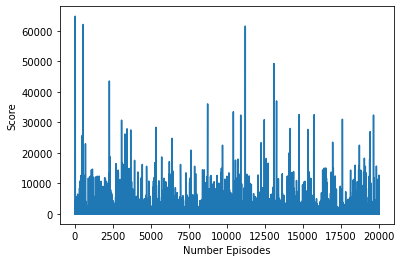

463.236


In [15]:
# Clipped DDQN

clipped_net1 = Policy(66, 4, dqn_hyperparams["hidden_size"])
clipped_net2 = Policy(66, 4, dqn_hyperparams["hidden_size"])
#clipped_net1 = EpsilonPolicy(66, 4, dqn_hyperparams["hidden_size"])
#clipped_net2 = EpsilonPolicy(66, 4, dqn_hyperparams["hidden_size"])
optimizer1 = torch.optim.Adam(clipped_net1.parameters())
optimizer2 = torch.optim.Adam(clipped_net2.parameters())

scores = clipped_double_q(clipped_net1, clipped_net2, optimizer1, optimizer2,
                     dqn_hyperparams["n_training_episodes"], dqn_hyperparams["time_limit"], 
                     dqn_hyperparams["gamma"], dqn_hyperparams["avg_rate"], 1000)

plt.plot(scores)
#plt.scatter([i for i in range(1, len(scores)+1)], scores)
plt.ylabel("Score")
plt.xlabel("Number Episodes")
plt.show()
print(sum(scores)/len(scores))

In [32]:
#Play 1 game and output the result at each time step
def play_game(network, time_limit):
    state, _ = env.reset()
    print(env.board)
    
    #For epsilon greedy policy
    #network.train = False
    
    for t in range(time_limit):
        action = network.act(state)
        new_state, reward, terminated, _, info = env.step(action)
        state = new_state
        
        print(env.board, f"Total score: {env.score}")
    
        if terminated == True:
            break
    
    return None

play_game(target_net, dqn_hyperparams["time_limit"])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] Total score: 0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3.]
 [4. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] Total score: 0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] Total score: 0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3.]
 [1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 4. 1.]
 [0. 0. 0. 0. 0

<ipython-input-6-a79eebd189da>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


DDQN Network result:


<ipython-input-6-01ec47aa7539>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Average score = 1438.12


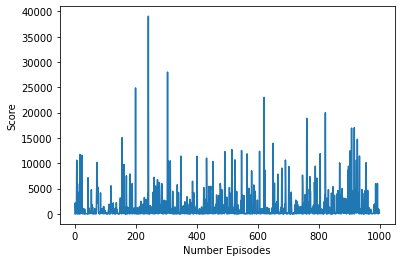

Clipped DDQN Network result:
Average score = 1472.14


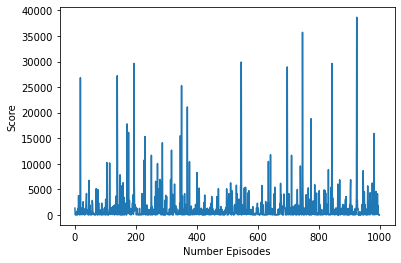

In [16]:
#Play multiple games without training and output the average score
def play_games(network, time_limit, num_games):
    scores = []
    for game in range(num_games):
        state, _ = env.reset()
        
        #For epsilon greedy policy
        #network.train = False

        for t in range(time_limit):
            action = network.act(state)
            new_state, reward, terminated, _, info = env.step(action)
            state = new_state

            if terminated == True:
                break
        scores.append(env.score)
    print(f"Average score = {sum(scores)/len(scores)}")
    return scores

print("DDQN Network result:")
scores = play_games(target_net, dqn_hyperparams["time_limit"], 1000)
plt.plot(scores)
#plt.scatter([i for i in range(1, len(scores)+1)], scores)
plt.ylabel("Score")
plt.xlabel("Number Episodes")
plt.show()
print("Clipped DDQN Network result:")
scores = play_games(clipped_net1, dqn_hyperparams["time_limit"], 1000)
plt.plot(scores)
#plt.scatter([i for i in range(1, len(scores)+1)], scores)
plt.ylabel("Score")
plt.xlabel("Number Episodes")
plt.show()

In [17]:
#Saving models to a file
torch.save(target_net.state_dict(), "ddqn_model.pt")
torch.save(clipped_net1.state_dict(), "cddqn_model.pt")

tensor([[0.0008, 0.0014, 0.0136, 0.0318, 0.3600, 0.1959, 0.0084, 0.0750, 0.3079,
         0.0053]], grad_fn=<SoftmaxBackward0>)
tensor(4)
tensor(0.3600, grad_fn=<SelectBackward0>)


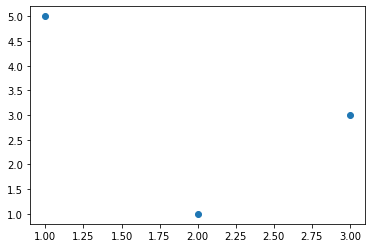

In [134]:
#Testing
x = torch.FloatTensor([5, 4, 7, 2, 1]).unsqueeze(0).to(device)
x = nn.Linear(5, 10)(x)
y = F.softmax(x, dim=1)
print(y)
print(torch.argmax(y))
print(y[0][torch.argmax(y)])
x = [5, 1, 3]
plt.scatter([i for i in range(1, len(x)+1)], x)